In [2]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.backends.backend_pdf import PdfPages
from scipy.integrate import simpson
from kernels import IonProb, IonRate, analyticalRate
from field_functions import LaserField
from __init__ import FourierTransform

class AU:
    meter = 5.2917720859e-11 # atomic unit of length in meters
    nm = 5.2917721e-2 # atomic unit of length in nanometres
    second = 2.418884328e-17 # atomic unit of time in seconds
    fs = 2.418884328e-2 # atomic unit of time in femtoseconds
    Joule = 4.359743935e-18 # atomic unit of energy in Joules
    eV = 27.21138383 # atomic unit of energy in electronvolts
    Volts_per_meter = 5.142206313e+11 # atomic unit of electric field in V/m
    Volts_per_Angstrom = 51.42206313 # atomic unit of electric field in V/Angström
    speed_of_light = 137.035999 # vacuum speed of light in atomic units
    Coulomb = 1.60217646e-19 # atomic unit of electric charge in Coulombs
    PW_per_cm2_au = 0.02849451308 # PW/cm^2 in atomic units
AtomicUnits=AU


file_params = [
    ("850nm_1e+14", 850, 1e13, 350, 1e10, 1, 0, -np.pi/2),
    #("850nm_1e+14", 850, 1e14, 350, 1e10, 1, 0, -np.pi/2),
    # ("850nm_350nm_7.5e+13", 850, 7.50e13, 350, 6.00e09, 0.93, 0, -np.pi/2),
    # ("900nm_320nm_5e+14", 900, 5e14, 320, 4e10, 0.75, 0, -np.pi/2),
    # ("1200nm_320nm_1e+14", 1200, 1e14, 320, 4e10, 0.75, 0, -np.pi/2),
    # ("900nm_250nm_8e+13", 900, 8e13, 250, 6e8, 0.58, 0, -np.pi/2),
    # ("900nm_250nm_9e+13", 900, 9e13, 250, 6e8, 0.58, 0, -np.pi/2),
    # ("900nm_250nm_1e+14", 900, 1e14, 250, 6e8, 0.58, 0, -np.pi/2),
    # ("900nm_250nm_1.1e+14", 900, 1.1e14, 250, 6e8, 0.58, 0, -np.pi/2),
]

params = {'E_g': 0.5, 'αPol': 4.51, 'tau': 2.849306230484045, 'e1': 2.2807090369952894, 't0': 0.1, 't1': 3.043736601676354, 't2': 7.270940402611973, 'e2': 0, 't3': 0, 't4': 1, "div_p":2**-4, "div_theta":1}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload
for file_name, lam0_pump, I_pump, lam0_probe, I_probe, FWHM_probe, cep_pump, cep_probe in file_params:
    laser_pulses = LaserField(cache_results=True)
    laser_pulses.add_pulse(lam0_pump, I_pump, cep_pump, lam0_pump/ AtomicUnits.nm / AtomicUnits.speed_of_light)
    t_min, t_max = laser_pulses.get_time_interval()
    time_recon= np.arange(t_min, t_max+1, 1)


    ion_na_rate_GASFIR = IonRate(time_recon, laser_pulses, params, dT=0.5, kernel_type='GASFIR')
    laser_pulses.reset()

In [4]:
%autoreload
for file_name, lam0_pump, I_pump, lam0_probe, I_probe, FWHM_probe, cep_pump, cep_probe in file_params:
    laser_pulses = LaserField(cache_results=True)
    laser_pulses.add_pulse(lam0_pump, I_pump, cep_pump, lam0_pump/ AtomicUnits.nm / AtomicUnits.speed_of_light)
    t_min, t_max = laser_pulses.get_time_interval()
    time_recon= np.arange(t_min, t_max+1, 1)


    ion_na_rate_SFA = IonRate(time_recon, laser_pulses, params, dT=0.5, kernel_type='exact_SFA')
    laser_pulses.reset()

Basis states (6): [|1,0,0>, |2,0,0>, |2,1,0>, |3,0,0>, |3,1,0>, |3,2,0>]
Basis states (6): [|1,0,0>, |2,0,0>, |2,1,0>, |3,0,0>, |3,1,0>, |3,2,0>]
Basis states (6): [|1,0,0>, |2,0,0>, |2,1,0>, |3,0,0>, |3,1,0>, |3,2,0>]
state 0 stateRange 0
config (1, 0, 0) configRange (1, 0, 0)


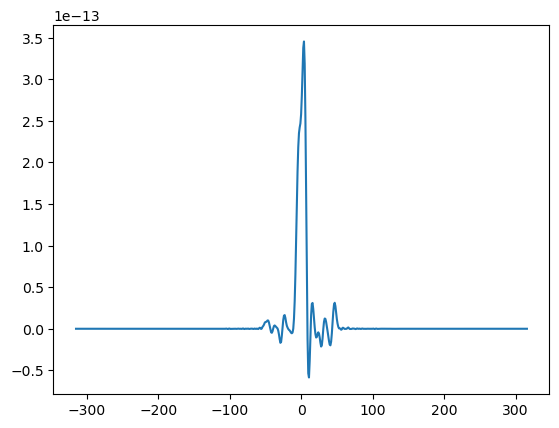

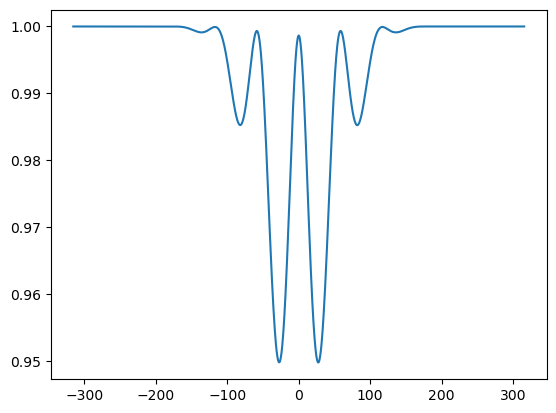

state 0 stateRange 1
config (1, 0, 0) configRange (2, 0, 0)


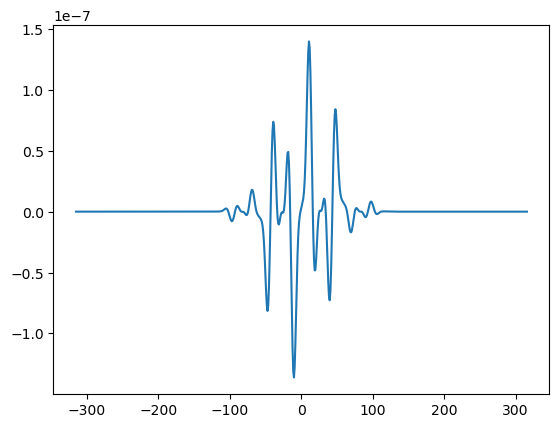

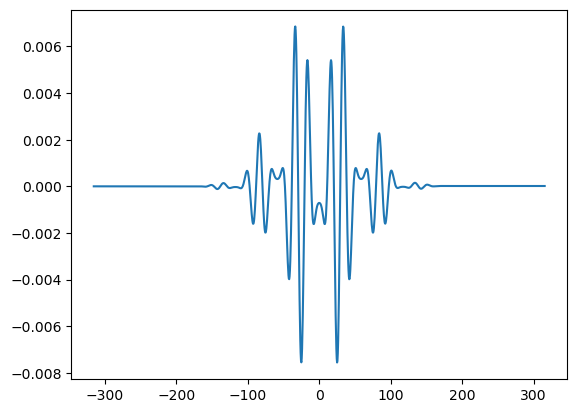

state 0 stateRange 2
config (1, 0, 0) configRange (2, 1, 0)


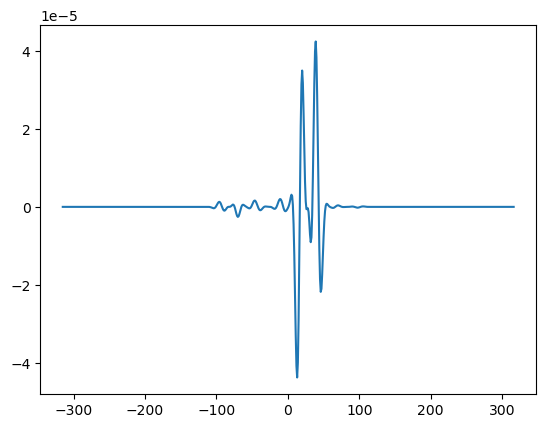

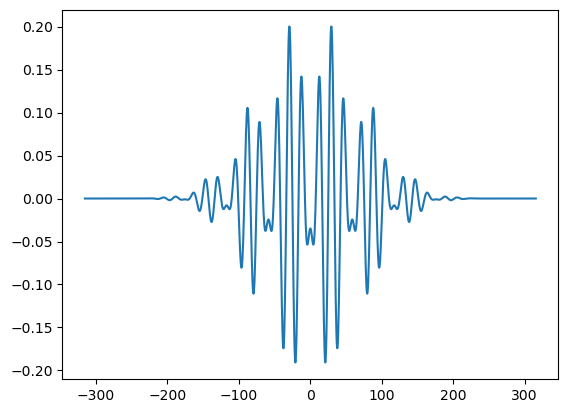

state 1 stateRange 0
config (2, 0, 0) configRange (1, 0, 0)


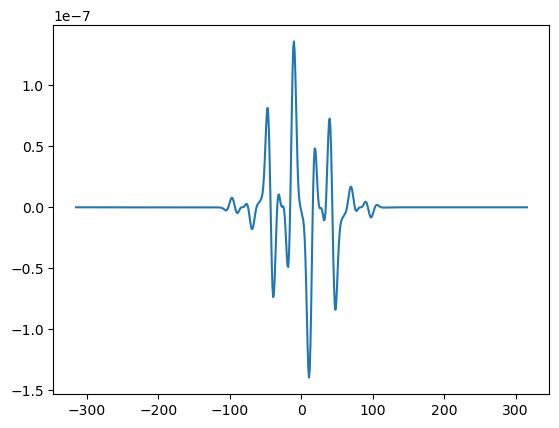

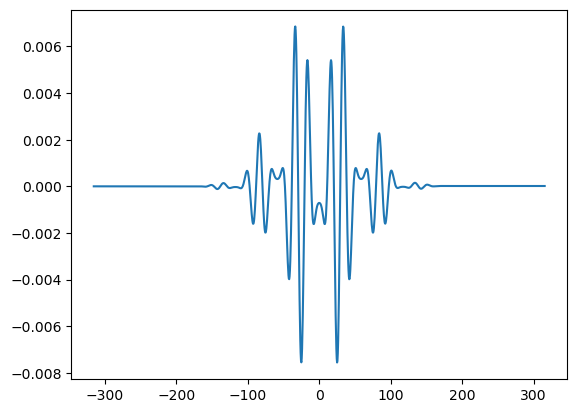

state 1 stateRange 1
config (2, 0, 0) configRange (2, 0, 0)


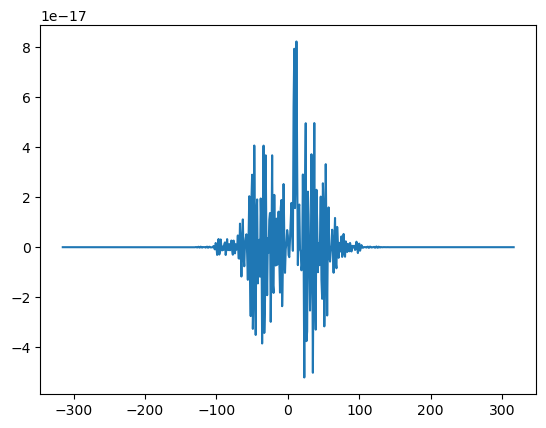

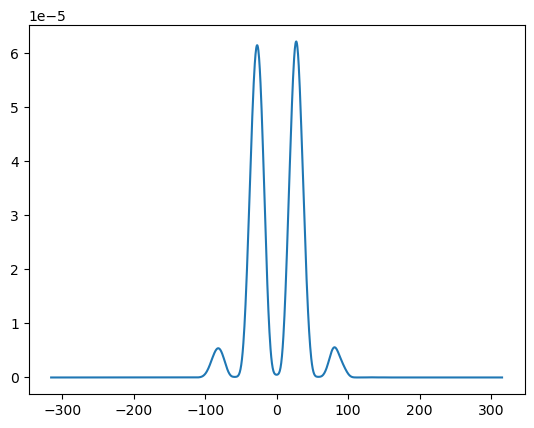

state 1 stateRange 2
config (2, 0, 0) configRange (2, 1, 0)


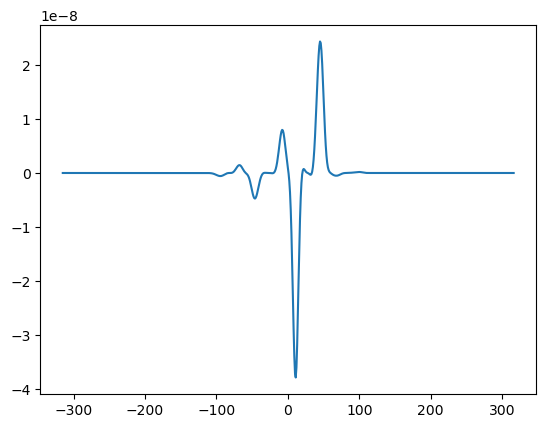

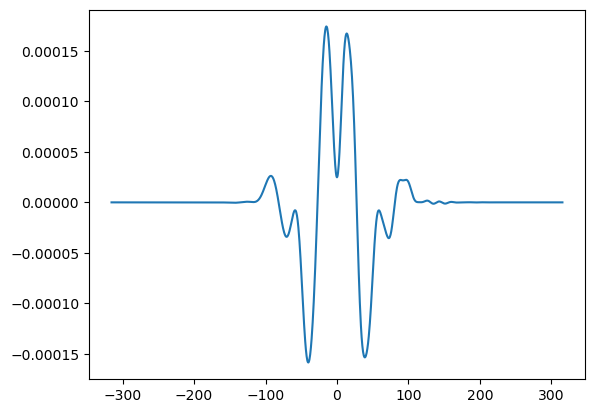

state 2 stateRange 0
config (2, 1, 0) configRange (1, 0, 0)


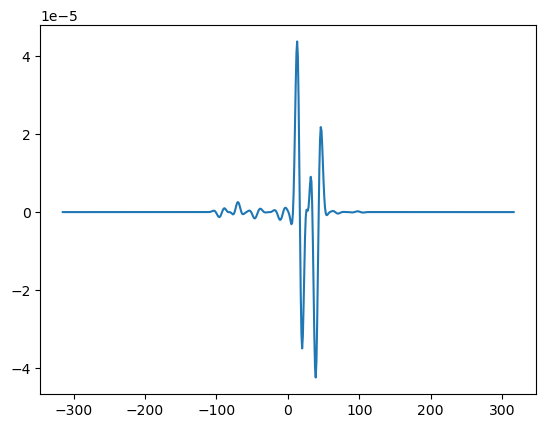

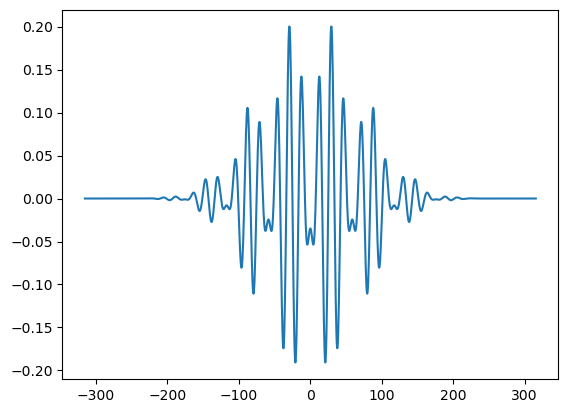

state 2 stateRange 1
config (2, 1, 0) configRange (2, 0, 0)


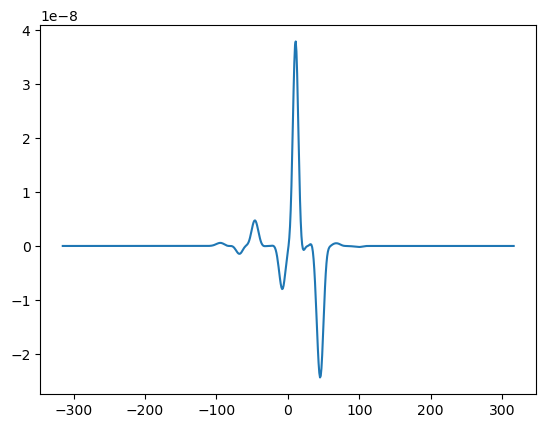

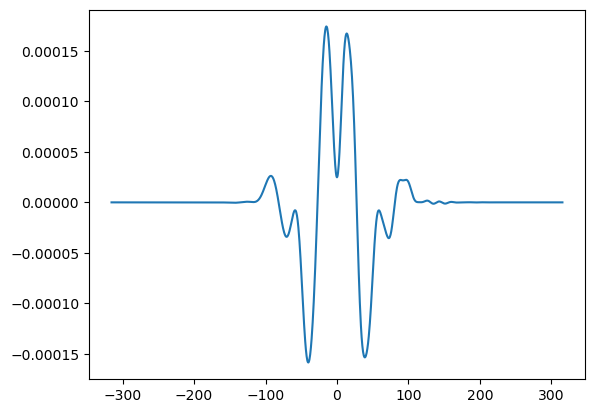

state 2 stateRange 2
config (2, 1, 0) configRange (2, 1, 0)


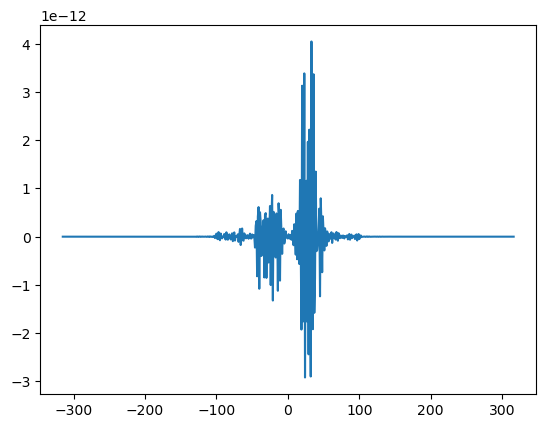

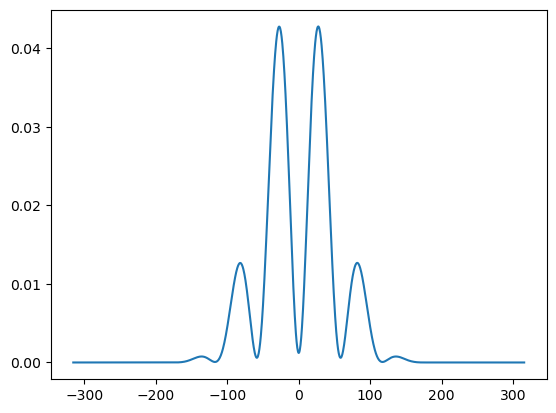

In [ ]:
%autoreload
for file_name, lam0_pump, I_pump, lam0_probe, I_probe, FWHM_probe, cep_pump, cep_probe in file_params:
    laser_pulses = LaserField(cache_results=True)
    laser_pulses.add_pulse(lam0_pump, I_pump, cep_pump, lam0_pump/ AtomicUnits.nm / AtomicUnits.speed_of_light)
    t_min, t_max = laser_pulses.get_time_interval()
    time_recon= np.arange(t_min, t_max+1, 1)


    ion_na_rate_SFA_excited = IonRate(time_recon, laser_pulses, params, dT=0.5, kernel_type='exact_SFA', excitedStates=2)
    #ionprob = IonProb(laser_pulses, params, dT=0.5, kernel_type='exact_SFA', excitedStates=2)
    #ion_na_rate_GASFIR = IonRate(time_recon, laser_pulses, params, dT=0.5, kernel_type='GASFIR')
    laser_pulses.reset()

In [6]:
print("ion_prob_GASFIR", 1-np.exp(-np.double(simpson(ion_na_rate_GASFIR, x=time_recon, axis=-1, even='simpson'))))
print("ion_prob_excited", 1-np.exp(-np.double(simpson(np.real(ion_na_rate_SFA_excited), x=time_recon, axis=-1, even='simpson'))))
print("ion_prob_SFA", 1-np.exp(-np.double(simpson(ion_na_rate_SFA, x=time_recon, axis=-1, even='simpson'))))
print("ion_prob_tRecX", 0.005064)

ion_prob_GASFIR 3.5268787890174735e-11
ion_prob_excited 3.855027408405931e-12
ion_prob_SFA 1.4011458659979326e-11
ion_prob_tRecX 0.005064


In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_recon, y=2*np.real(ion_na_rate_SFA_excited), mode='lines', name='SFA_excited')) #they are exactly 4pi apart
fig.add_trace(go.Scatter(x=time_recon, y=ion_na_rate_SFA, mode='lines', name='SFA'))

fig.update_layout(
    title=f'Ionization Rate Comparison for {file_name}',
    xaxis_title='Time (a.u.)',
    yaxis_title='Ionization Rate (a.u.)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    xaxis_range=[-100, 100],
    width=800,
    height=600
)
# truncate y-axis
fig.show()